#### Import libraries

In [1]:
import pandas as pd
import datetime as dt

#### Load data

In [2]:
df = pd.read_csv('./app/data/data.csv')

#### Clean data

In [3]:
# Convert object columns to numeric
df['land_size_sqm'] = pd.to_numeric(df['land_size_sqm'].str.replace(' sqm', ''))
df['house_size_sqm'] = pd.to_numeric(df['house_size_sqm'].str.replace(' sqm', ''))
df['distance_to_school'] = pd.to_numeric(df['distance_to_school'].str.replace('km', ''))
df['distance_to_supermarket'] = pd.to_numeric(df['distance_to_supermarket'].str.replace(' km', ''))
df['house_age'] = pd.to_numeric(df['house_age'].str.replace(' Years', ''))

# Convert Yes/No columns to 1/0
df['large_living_room'] = pd.to_numeric(df['large_living_room'].replace({'No': '0', 'Yes': '1'}))
df['parking_space'] = pd.to_numeric(df['parking_space'].replace({'No': '0', 'Yes': '1'}))
df['front_garden'] = pd.to_numeric(df['front_garden'].replace({'No': '0', 'Yes': '1'}))
df['swimming_pool'] = pd.to_numeric(df['swimming_pool'].replace({'No': '0', 'Yes': '1'}))
df['wall_fence'] = pd.to_numeric(df['wall_fence'].replace({'No': '0', 'Yes': '1'}))
df['water_front'] = pd.to_numeric(df['water_front'].replace({'No': '0', 'Yes': '1'}))
df['room_size'] = pd.to_numeric(df['room_size'].replace({'small': '0', 'medium': '1', 'large': '2', 'extra_large': '3'}))


#### Exploratory Data Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

<Axes: xlabel='property_value', ylabel='Count'>

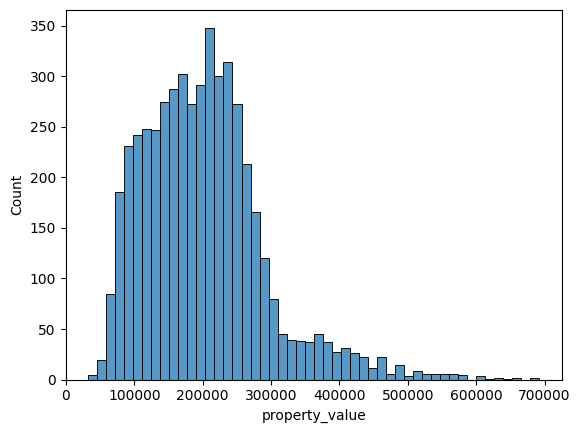

In [5]:
# Plot house prices. We can see there is a long tail effect.
sns.histplot(df.property_value, bins=50)

In [6]:
# Remove long tail by applying log+1 to house price
price_log = np.log1p(df.property_value)

<Axes: xlabel='property_value', ylabel='Count'>

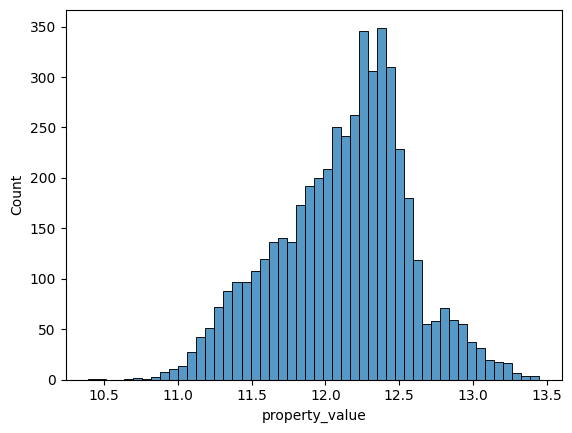

In [7]:
# Plot log+1 house prices
sns.histplot(price_log, bins=50)

In [8]:
# Check for missing values. We don't have any missing values.
df.isnull().sum()

house_id                   0
land_size_sqm              0
house_size_sqm             0
no_of_rooms                0
no_of_bathrooms            0
large_living_room          0
parking_space              0
front_garden               0
swimming_pool              0
distance_to_school         0
wall_fence                 0
house_age                  0
water_front                0
distance_to_supermarket    0
crime_rate_index           0
room_size                  0
property_value             0
dtype: int64

#### Validation framework

In [9]:
# We split our dataset into train (60%), val (20%) and test (20%) datasets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
# We reset the dataframes index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
# Get target variable from the train, val, test datasets
y_train = np.log1p(df_train['property_value'].values)
y_val = np.log1p(df_val['property_value'].values)
y_test = np.log1p(df_test['property_value'].values)

In [12]:
# Delete the target variable from the datasets
del df_train['property_value']
del df_val['property_value']
del df_test['property_value']

In [13]:
# Save test data to a csv file
df_test.to_csv('./app/data/test.csv')

#### Feature importance

In [14]:
from sklearn.feature_selection import mutual_info_regression

In [15]:
# We calculate the feature importance. We use the mutual_info_regression function which is more suitable for 
# numerical features. We see that Land Size and House Size are the most important features, followed by the 
# number of rooms and number of bathrooms.
X = df_full_train.drop(columns=['property_value'])
y = df_full_train['property_value']

mi_scores = mutual_info_regression(X, y)

mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': mi_scores
}).sort_values(by='Score', ascending=False)

mi_scores_df

,Feature,Score
1,land_size_sqm,1.448084
2,house_size_sqm,1.272001
3,no_of_rooms,1.022693
4,no_of_bathrooms,0.353795
8,swimming_pool,0.252753
7,front_garden,0.231389
10,wall_fence,0.201655
6,parking_space,0.167548
5,large_living_room,0.131722
15,room_size,0.074475


#### Train model

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error

In [17]:
# Create dictionaries
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

In [18]:
# Create vectorizer
dv = DictVectorizer(sparse=True)

# Create feature matrices
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

##### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
# Use train dataset to make predictions with lr
y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.101723968693931)

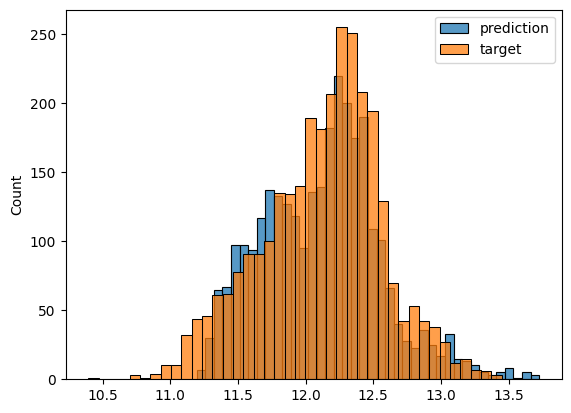

In [22]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_train, label='target', bins=40)
plt.legend()

In [23]:
# Check the model on validation dataset
y_pred = lr.predict(X_val)

In [24]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.09909905136174671)

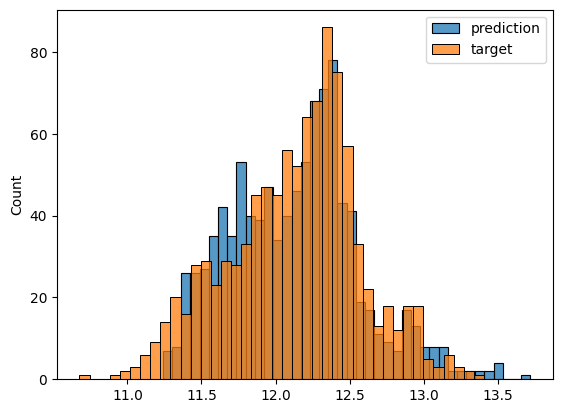

In [25]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_val, label='target', bins=40)
plt.legend()

##### Decision tree

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
# Train decision tree model with multiple max_depth values

scores = []

for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]:
    dt = DecisionTreeRegressor(max_depth=d, random_state=1)
    dt.fit(X_train, y_train)

    # Use val dataset to make predictions with dt
    y_pred = dt.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    scores.append((d, rmse))


In [28]:
scores

[(1, np.float64(0.2796128149755299)),
 (2, np.float64(0.1752646701309192)),
 (3, np.float64(0.13956559597005203)),
 (4, np.float64(0.11925012404851036)),
 (5, np.float64(0.10981674766398956)),
 (6, np.float64(0.10604223285321498)),
 (7, np.float64(0.10072391102822972)),
 (8, np.float64(0.09783227933387273)),
 (9, np.float64(0.09892240085101223)),
 (10, np.float64(0.0982938756075467)),
 (15, np.float64(0.10233441039966337)),
 (20, np.float64(0.10219422403368304))]

In [29]:
# Now we train with max_depth=8 which gave us the best RMSE value
dt = DecisionTreeRegressor(max_depth=8)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

In [30]:
# Use train dataset to make predictions with dt and calculate RMSE
y_pred = dt.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.06429590137201383)

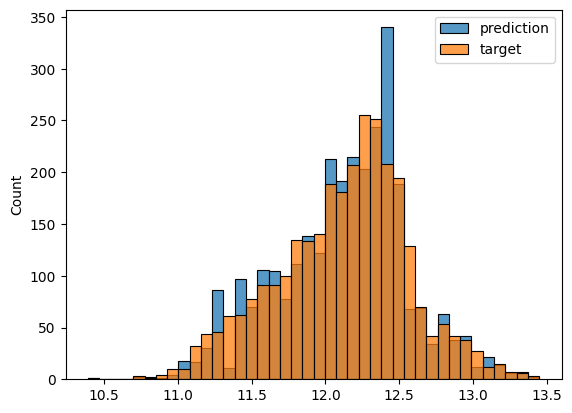

In [31]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_train, label='target', bins=40)
plt.legend()

In [32]:
# Check the model on validation dataset
y_pred = dt.predict(X_val)

In [33]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.09965216808629587)

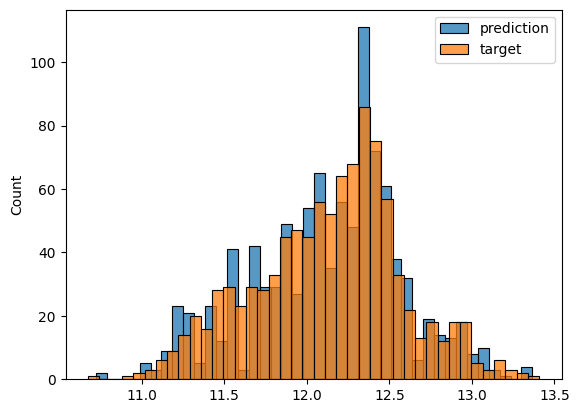

In [34]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_val, label='target', bins=40)
plt.legend()

##### Random forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
# Train random forest model with multiple max_depth and n_estimators values

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, rmse))

In [37]:
scores

[(1, np.float64(0.2796128149755299)),
 (2, np.float64(0.1752646701309192)),
 (3, np.float64(0.13956559597005203)),
 (4, np.float64(0.11925012404851036)),
 (5, np.float64(0.10981674766398956)),
 (6, np.float64(0.10604223285321498)),
 (7, np.float64(0.10072391102822972)),
 (8, np.float64(0.09783227933387273)),
 (9, np.float64(0.09892240085101223)),
 (10, np.float64(0.0982938756075467)),
 (15, np.float64(0.10233441039966337)),
 (20, np.float64(0.10219422403368304)),
 (5, 10, np.float64(0.09747099284090516)),
 (5, 20, np.float64(0.0968688035837062)),
 (5, 30, np.float64(0.09696688854374441)),
 (5, 40, np.float64(0.09650829977475486)),
 (5, 50, np.float64(0.0961039793281343)),
 (5, 60, np.float64(0.09591571917361418)),
 (5, 70, np.float64(0.09574258680217285)),
 (5, 80, np.float64(0.09564675577431019)),
 (5, 90, np.float64(0.09565334200628973)),
 (5, 100, np.float64(0.09563015358887751)),
 (5, 110, np.float64(0.09553966034958093)),
 (5, 120, np.float64(0.09561208530224823)),
 (5, 130, np.fl

In [38]:
# Train random forest
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=1)

In [39]:
# Use train dataset to make predictions with rf and calculate RMSE
y_pred = rf.predict(X_train)
root_mean_squared_error(y_train, y_pred)

np.float64(0.025751576898968447)

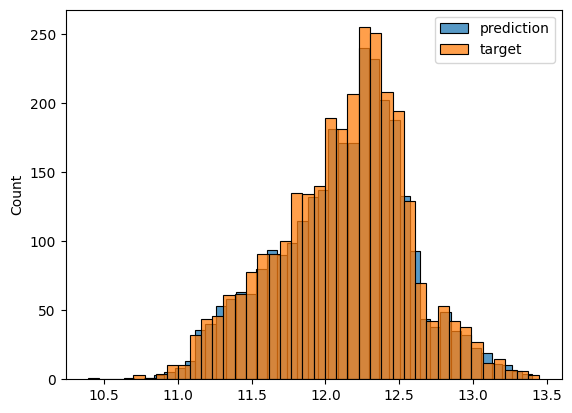

In [40]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_train, label='target', bins=40)
plt.legend()

In [41]:
# Check the model on validation dataset
y_pred = rf.predict(X_val)

In [42]:
# Calculate RMSE for target values and predictions on the validation dataset
root_mean_squared_error(y_val, y_pred)

np.float64(0.06546849147155659)

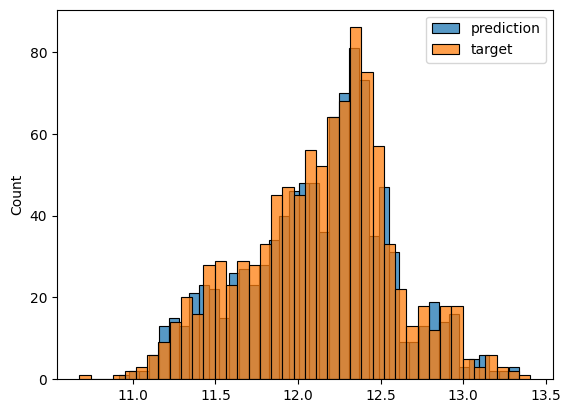

In [43]:
# Show target values and predictions on a histogram
sns.histplot(y_pred, label='prediction', bins=40)
sns.histplot(y_val, label='target', bins=40)
plt.legend()

#### Use model

In [44]:
# Select a house
house_dict = {
 'land_size_sqm': 115.0,
 'house_size_sqm': 113.0,
 'no_of_rooms': 1.0,
 'no_of_bathrooms': 1.0,
 'large_living_room': 0.0,
 'parking_space': 0.0,
 'front_garden': 0.0,
 'swimming_pool': 0.0,
 'distance_to_school': 2.6,
 'wall_fence': 0.0,
 'house_age': 21.0,
 'water_front': 0.0,
 'distance_to_supermarket': 4.7,
 'crime_rate_index': 5.64,
 'room_size': 2.0
 }

# Create feature matrix for selected house
X_house = dv.transform(house_dict)

In [45]:
# Predict price with Random Forest model
y_house_pred = np.expm1(rf.predict(X_house))
y_house_pred

array([68941.82080002])